In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from astropy.time import Time, TimeDelta
from astropy.timeseries import TimeSeries, aggregate_downsample
import astropy.units as u

from sklearn.decomposition import PCA
import random
from sklearn import preprocessing
%matplotlib inline

## path to file with NIRSpec Data
file_nirspec = 'jw03548003001_03101_00001-seg001_nrs1_x1dints.fits'

## use astropy module for reading fits file
hdu_n = fits.open(file_nirspec)

time_array = hdu_n[1].data.field('int_mid_BJD_TDB')
print(f"This is the list of times in days {time_array}")

## now let's read the spectra into an array
n_times = len(time_array)

n_wpts = 431 ## I just read this number from the earlier output.

## set up empty arrays for wavelength, flux and flux error:
w = np.zeros((n_wpts, n_times))
f = w * 0
fe = f * 0

for i in range(0, n_wpts):
    for j in range(2, n_times + 2):
        w[i, j - 2] = hdu_n[j].data[i][0]
        f[i, j - 2] = hdu_n[j].data[i][1]
        fe[i, j - 2] = hdu_n[j].data[i][2]

# Convert to units
wNewUnit = w
fNewUnit = 2.9979E+14 * (f) / (w) ** 2 * 1E-26
feNewUnit = 2.9979E+14 * (fe) / (w) ** 2 * 1E-26

This is the list of times in days [60148.79920059 60148.79922177 60148.79924295 ... 60148.92042627
 60148.92044745 60148.92046863]


In [3]:
# LIGHT CURVE MARIO FABELO

# Define wavelength range
wavelength_min = 1.2  # microns
wavelength_max = 1.3  # microns
J_lc = np.zeros(len(time_array))


# Extract flux values within the wavelength range
print(fNewUnit.shape)

for i in range(0,len(time_array)):
    wavelength_indices = np.where(np.logical_and(wNewUnit[:,i] >= wavelength_min, wNewUnit[:,i] <= wavelength_max))[0]
    flux_within_range = fNewUnit[wavelength_indices,i]
    J_lc[i] = np.median(flux_within_range)

### normalise the light curve to 1
norm = np.median(J_lc)
J_lc = J_lc/ norm

(431, 5726)


1.8301405711099505
0.03050234285183251 min between flux measurements
       time               flux       
------------------ ------------------
60148.799200587586  1.001599947811374
 60148.79922176977  1.003703539357196
60148.799242951965 1.0074832718839468
 60148.79926413416 1.0026937184193363
60148.799285316345 1.0079507175479203
 60148.79930649854  1.005337730714328
 60148.79932768073 1.0133478422043687
 60148.79934886292 0.9980994352677334
 60148.79937004512 1.0057064612379003
 60148.79939122731 1.0020175460666207
               ...                ...
60148.920277994555   1.00574678088427
 60148.92029917675 1.0020386408835593
60148.920320358935 1.0035419030353463
 60148.92034154113  1.004850603324406
 60148.92036272332 0.9972087331575109
 60148.92038390551 0.9996628050995381
 60148.92040508771 0.9999960142604993
 60148.92042626989 1.0030933574720111
 60148.92044745209 1.0095154271899969
 60148.92046863428  0.995122835399558
Length = 5726 rows


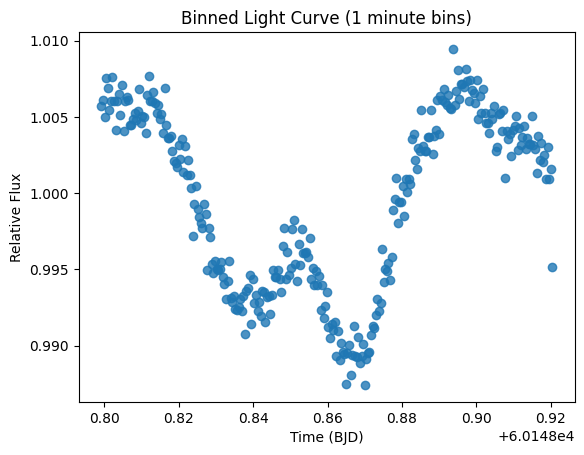

In [4]:
# Binning (condensing data to obtain a clearer visual trend)

# What is the cadence (difference between timestamps)
print((time_array[1] - time_array[0])*24*60*60)   # in seconds

cadence = (time_array[1] - time_array[0])*24*60   # in minutes
print(f"{cadence} min between flux measurements")


# Convert time_array to astropy Time object
time = Time(time_array, format='mjd', scale='tdb')

# Create a TimeSeries object
ts = TimeSeries(time=time, data={'flux':J_lc})
print(ts)

# Define the binning duration in minutes

#bin_width = 1  # minute (for standard light curve)
bin_width = 0.6105  # minute (for overlay light curve NIRIS, full)
#bin_width = 1.53  # minute (for overlay light curve HST)

# Perform binning
binned_lc = aggregate_downsample(ts, time_bin_size=bin_width * u.minute, aggregate_func=np.median)

# Extract binned time and flux values
binned_time = binned_lc.time_bin_start.mjd
binned_flux = binned_lc['flux']

# Plot the binned light curve
plt.scatter(binned_time, binned_flux, marker='o', linestyle='-', alpha=0.8)
plt.xlabel("Time (BJD)")
plt.ylabel("Relative Flux")
plt.title("Binned Light Curve (1 minute bins)")
#plt.savefig("binned_light_curve_1_min_.png")
plt.show()

In [5]:
# PCA JENNIFER KESTELL

def MedianCombineSpectra(fluxDataSet, wavelengthDataSet, combinedSpectra):

    combinedf = np.empty((0, len(wavelengthDataSet)), dtype = 'int')

    for i in range(0, len(fluxDataSet), combinedSpectra):
        segment = fluxDataSet[i: i+10]

        median = np.median(segment, axis=0, keepdims = True)
        combinedf = np.append(combinedf, median, axis=0)

    return combinedf

def MedianCombineTime(timeDataSet, wavelengthDataSet, combinedTime):

    combinedt = np.empty((0), dtype = 'float')
    print(combinedt.shape)

    for i in range(0, len(timeDataSet), combinedTime):
        segment = timeDataSet[i: i+10]

        median = np.median(segment, axis=0, keepdims = True)

        combinedt = np.append(combinedt, median, axis=0)

    return combinedt

In [6]:
# Correct for noise data
newf = fNewUnit[13:-10]
neww = wNewUnit[13:-10]
newfe = feNewUnit[13: -10]

newf = np.delete(newf, 2335, 1)
neww = np.delete(neww,  2335, 1)
newfe = np.delete(newfe, 2335, 1)
time_array = np.delete(time_array, 2335)
newf= np.transpose(newf)

(0,)
(287, 1)
The shape of the PC is (287, 1)
The shape of the binned flux is (287,)


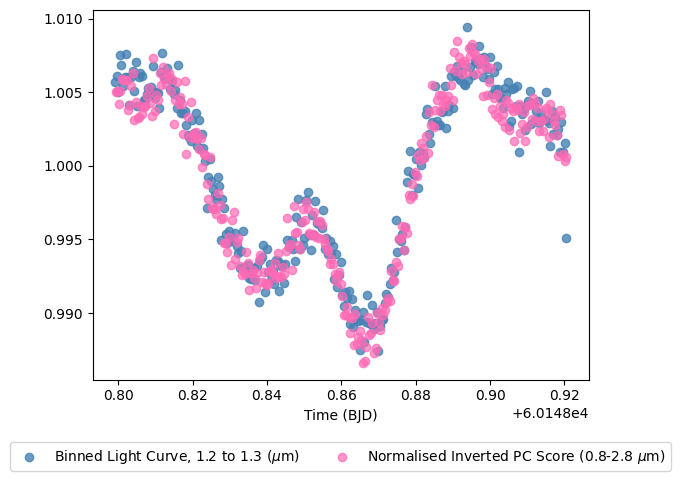

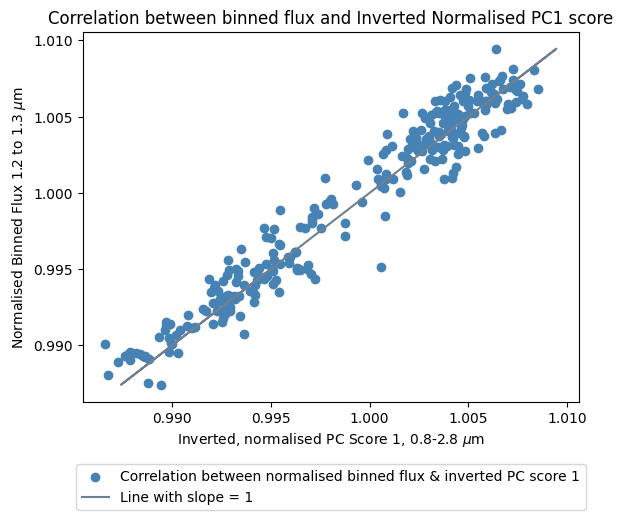

In [34]:
#0.8-2.794 micron like the NIRIS wavelength with high resolution

NIRISw = neww[32:153]
newf= np.transpose(newf)
NIRISf = newf[32:153]
newf= np.transpose(newf)
NIRISf= np.transpose(NIRISf)
NIRISw.shape

combinedf = MedianCombineSpectra(NIRISf, NIRISw, 20)
combinedt = MedianCombineTime(time_array, NIRISw, 20)

pca = PCA()
pca.fit(combinedf)


# PCA 1st COMPONENT
PC1 = pca.transform(combinedf)[:,:1]
print(PC1.shape)

normPC1 = preprocessing.normalize(PC1, axis=0)

#norm = np.median(PC1)
#normPC1 = PC1/norm

#print(norm)

shiftedNormPC1 = normPC1
# Calculate the range of invertShiftedNormPC1
data_range = np.max(shiftedNormPC1) - np.min(shiftedNormPC1)
# Calculate the mirrored values
mirrored_data = data_range - shiftedNormPC1 + np.min(shiftedNormPC1)
invertShiftedNormPC1 = (mirrored_data*-0.1) + 1.0085


print(f"The shape of the PC is {invertShiftedNormPC1.shape}")
print(f"The shape of the binned flux is {binned_flux.shape}")

plt.figure()


# PLOT BINNED LIGHT CURVE & PCA 1ST COMPONENT

### Plot Binned Light Curve between 1.15 to 1.25 microns
plt.scatter(binned_time, binned_flux, marker='o', linestyle='-', label = f'Binned Light Curve, {wavelength_min} to {wavelength_max} ($\mu$m)', color = 'steelblue', alpha = 0.8)
#plt.ylabel("Relative Flux")
#plt.title("Binned Light Curve (1 minute bins)")


### Plot PCA 1st Component
plt.scatter(combinedt, invertShiftedNormPC1, label= 'Normalised Inverted PC Score (0.8-2.8 $\mu$m)', color = 'hotpink', alpha = 0.7)
plt.xlabel("Time (BJD)")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol = 2)
#plt.savefig(f'Light Curve PC Score Overlay NIRIS {wavelength_min} to {wavelength_max} $\mu$m.jpg', dpi = 300, bbox_inches='tight')

# Plot Binned Flux vs Inversed Normalised PCA
plt.figure()
plt.scatter(invertShiftedNormPC1, binned_flux, color = 'steelblue', label = 'Correlation between normalised binned flux & inverted PC score 1')
plt.xlabel('Inverted, normalised PC Score 1, 0.8-2.8 $\mu$m')
plt.ylabel(f'Normalised Binned Flux {wavelength_min} to {wavelength_max} $\mu$m')

#gradient 1 comparison
plt.plot(binned_flux, binned_flux,label = 'Line with slope = 1' , color = 'slategrey')
plt.title("Correlation between binned flux and Inverted Normalised PC1 score")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))
plt.savefig("ratio binned flux to inverted Normalised PC1 NIRIS.jpg", dpi = 300, bbox_inches='tight')

#plt.savefig(f'Binned flux vs PC Score Overlay NIRIS {wavelength_min} to {wavelength_max} $\mu$m.jpg')

[[1.10236371 1.10236371 1.10236371 ... 1.10236371 1.10236371 1.10236371]
 [1.11892426 1.11892426 1.11892426 ... 1.11892426 1.11892426 1.11892426]
 [1.13578618 1.13578618 1.13578618 ... 1.13578618 1.13578618 1.13578618]
 ...
 [4.99011469 4.99011469 4.99011469 ... 4.99011469 4.99011469 4.99011469]
 [4.99797916 4.99797916 4.99797916 ... 4.99797916 4.99797916 4.99797916]
 [5.00583124 5.00583124 5.00583124 ... 5.00583124 5.00583124 5.00583124]]
(0,)
(287, 1)


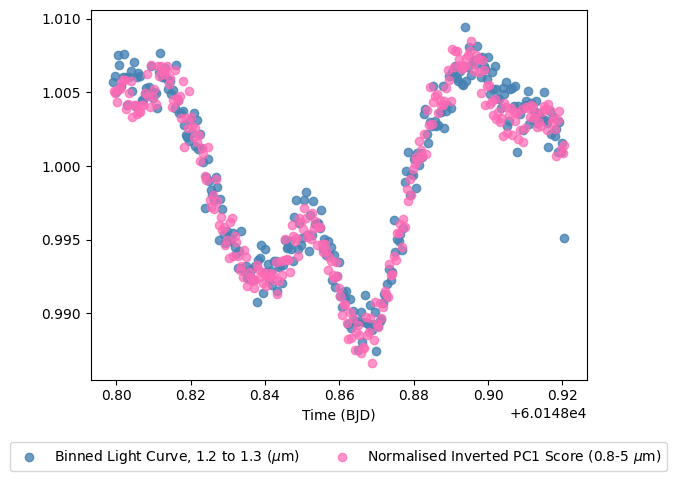

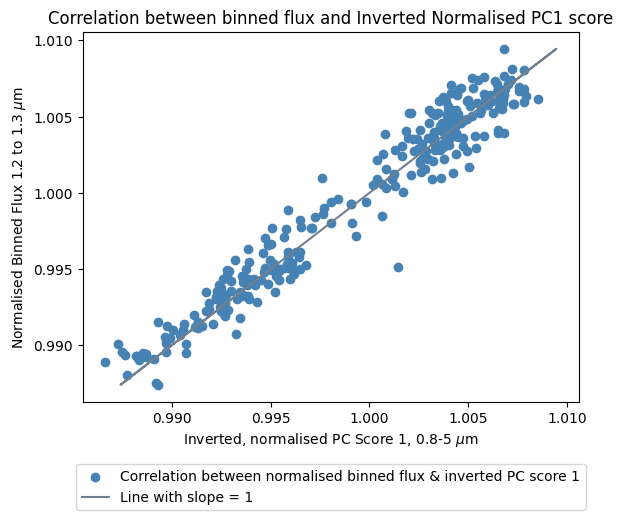

In [37]:
# Overlay full NIRSpec (0.8-5 micron)

fullNIRw = neww[56:370]
print(fullNIRw)
newf= np.transpose(newf)
fullNIRf = newf[56:370]
newf= np.transpose(newf)
fullNIRf= np.transpose(fullNIRf)
fullNIRw.shape

combinedf = MedianCombineSpectra(fullNIRf, fullNIRw, 20)
combinedt = MedianCombineTime(time_array, fullNIRw, 20)

pca = PCA()
pca.fit(combinedf)


# PCA 1st COMPONENT
PC1 = pca.transform(combinedf)[:,:1]
print(PC1.shape)

normPC1 = preprocessing.normalize(PC1, axis=0)

#norm = np.median(PC1)
#normPC1 = PC1/norm

#print(norm)

shiftedNormPC1 = normPC1
shiftedNormPC1 = normPC1
# Calculate the range of invertShiftedNormPC1
data_range = np.max(shiftedNormPC1) - np.min(shiftedNormPC1)
# Calculate the mirrored values
mirrored_data = data_range - shiftedNormPC1 + np.min(shiftedNormPC1)
invertShiftedNormPC1 = (mirrored_data*-0.1) + 1.0085

plt.figure()


# PLOT BINNED LIGHT CURVE & PCA 1ST COMPONENT

### Plot Binned Light Curve between 1.15 to 1.25 microns
plt.scatter(binned_time, binned_flux, marker='o', linestyle='-', label = f'Binned Light Curve, {wavelength_min} to {wavelength_max} ($\mu$m)', color = 'steelblue', alpha = 0.8)
#plt.ylabel("Relative Flux")
#plt.title("Binned Light Curve (1 minute bins)")


### Plot PCA 1st Component
plt.scatter(combinedt, invertShiftedNormPC1, label= 'Normalised Inverted PC1 Score (0.8-5 $\mu$m)', color = 'hotpink', alpha = 0.7)

plt.xlabel("Time (BJD)")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol = 2)
#plt.savefig(f'Light Curve PC Score Overlay full {wavelength_min} to {wavelength_max}.jpg', dpi = 300, bbox_inches='tight')



# Plot Binned Flux vs Inversed Normalised PCA
plt.figure()
plt.scatter(invertShiftedNormPC1, binned_flux, color = 'steelblue', label = 'Correlation between normalised binned flux & inverted PC score 1')
plt.xlabel('Inverted, normalised PC Score 1, 0.8-5 $\mu$m')
plt.ylabel(f'Normalised Binned Flux {wavelength_min} to {wavelength_max} $\mu$m')

#gradient 1 comparison
plt.plot(binned_flux, binned_flux,label = 'Line with slope = 1' , color = 'slategrey')
plt.title("Correlation between binned flux and Inverted Normalised PC1 score")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))
plt.savefig("ratio binned flux to inverted Normalised PC1 Full.jpg", dpi = 300, bbox_inches='tight')